## 📚 Exercise 1: Introducing Word Embeddings

In this exercise, we would train word embeddings from a state-of-the-art embeddings library (fastText). 

### Goal:
1. Load pretrained word embeddings using fastText library for `epfldocs.txt` data file
2. Visualize the embeddings using t-SNE algorithm
2. Find similar words by compuning the cosine similarity of their embedding vectors


### What you are learning in this exercise:
- Train word embeddings using fastText library
- Learn one way to visualize word embeddings
- How to use word embeddings to find similar words

### 1. FastText installation
The first step of the exercise is to install the fasttext library. Proceed with the following steps:

> pip install fasttext

If you are having problems, try this command:
> sudo apt-get install g++

### 2.1. Generate Embeddings

In [11]:
import fasttext
import numpy as np

model = fasttext.train_unsupervised('epfldocs.txt', model = 'cbow')
vocabulary = model.words
word_embeddings = np.array([model[word] for word in vocabulary])

Read 0M words
Number of words:  432
Number of labels: 0
Progress: 100.0% words/sec/thread:  138220 lr:  0.000000 avg.loss:  3.329919 ETA:   0h 0m 0s


### 2.2. Use Pretrained Embeddings
If you are unable to install fasttext, you can use the preembeddings we provide (`model_epfldocs.vec`).

In [4]:
import sys
import codecs
import numpy as np

# Edit this, or just move model_epfldocs.vec to the directory where this notebook is situated
directory_path = './'

def load_embeddings(file_name):
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        lines = f_in.readlines()
        lines = lines[1:]
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
    wv = np.loadtxt(wv)
    return wv, vocabulary


# Replace the path based on your own machine.
word_embeddings, vocabulary = load_embeddings(directory_path + 'model_epfldocs.vec')




### 3. Visualize Embeddings

In the third phase of this exercise, we will visualize the generated embeddings using t-SNE (T-Distributed Stochastic Neighbouring Entities).

t-SNE is a dimensionality reduction algorithm which is well suited for such visualization tasks.


In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import logging

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, init = 'pca') # Changed the parameters for provided in the exercise for less KL divergence and better readibility
vis_data = tsne.fit_transform(word_embeddings)

/opt/anaconda3/envs/adaexam/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/adaexam/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 432 samples in 0.000s...
[t-SNE] Computed neighbors for 432 samples in 0.013s...
[t-SNE] Computed conditional probabilities for sample 432 / 432
[t-SNE] Mean sigma: 0.074066
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.032646
[t-SNE] KL divergence after 1000 iterations: 0.118163


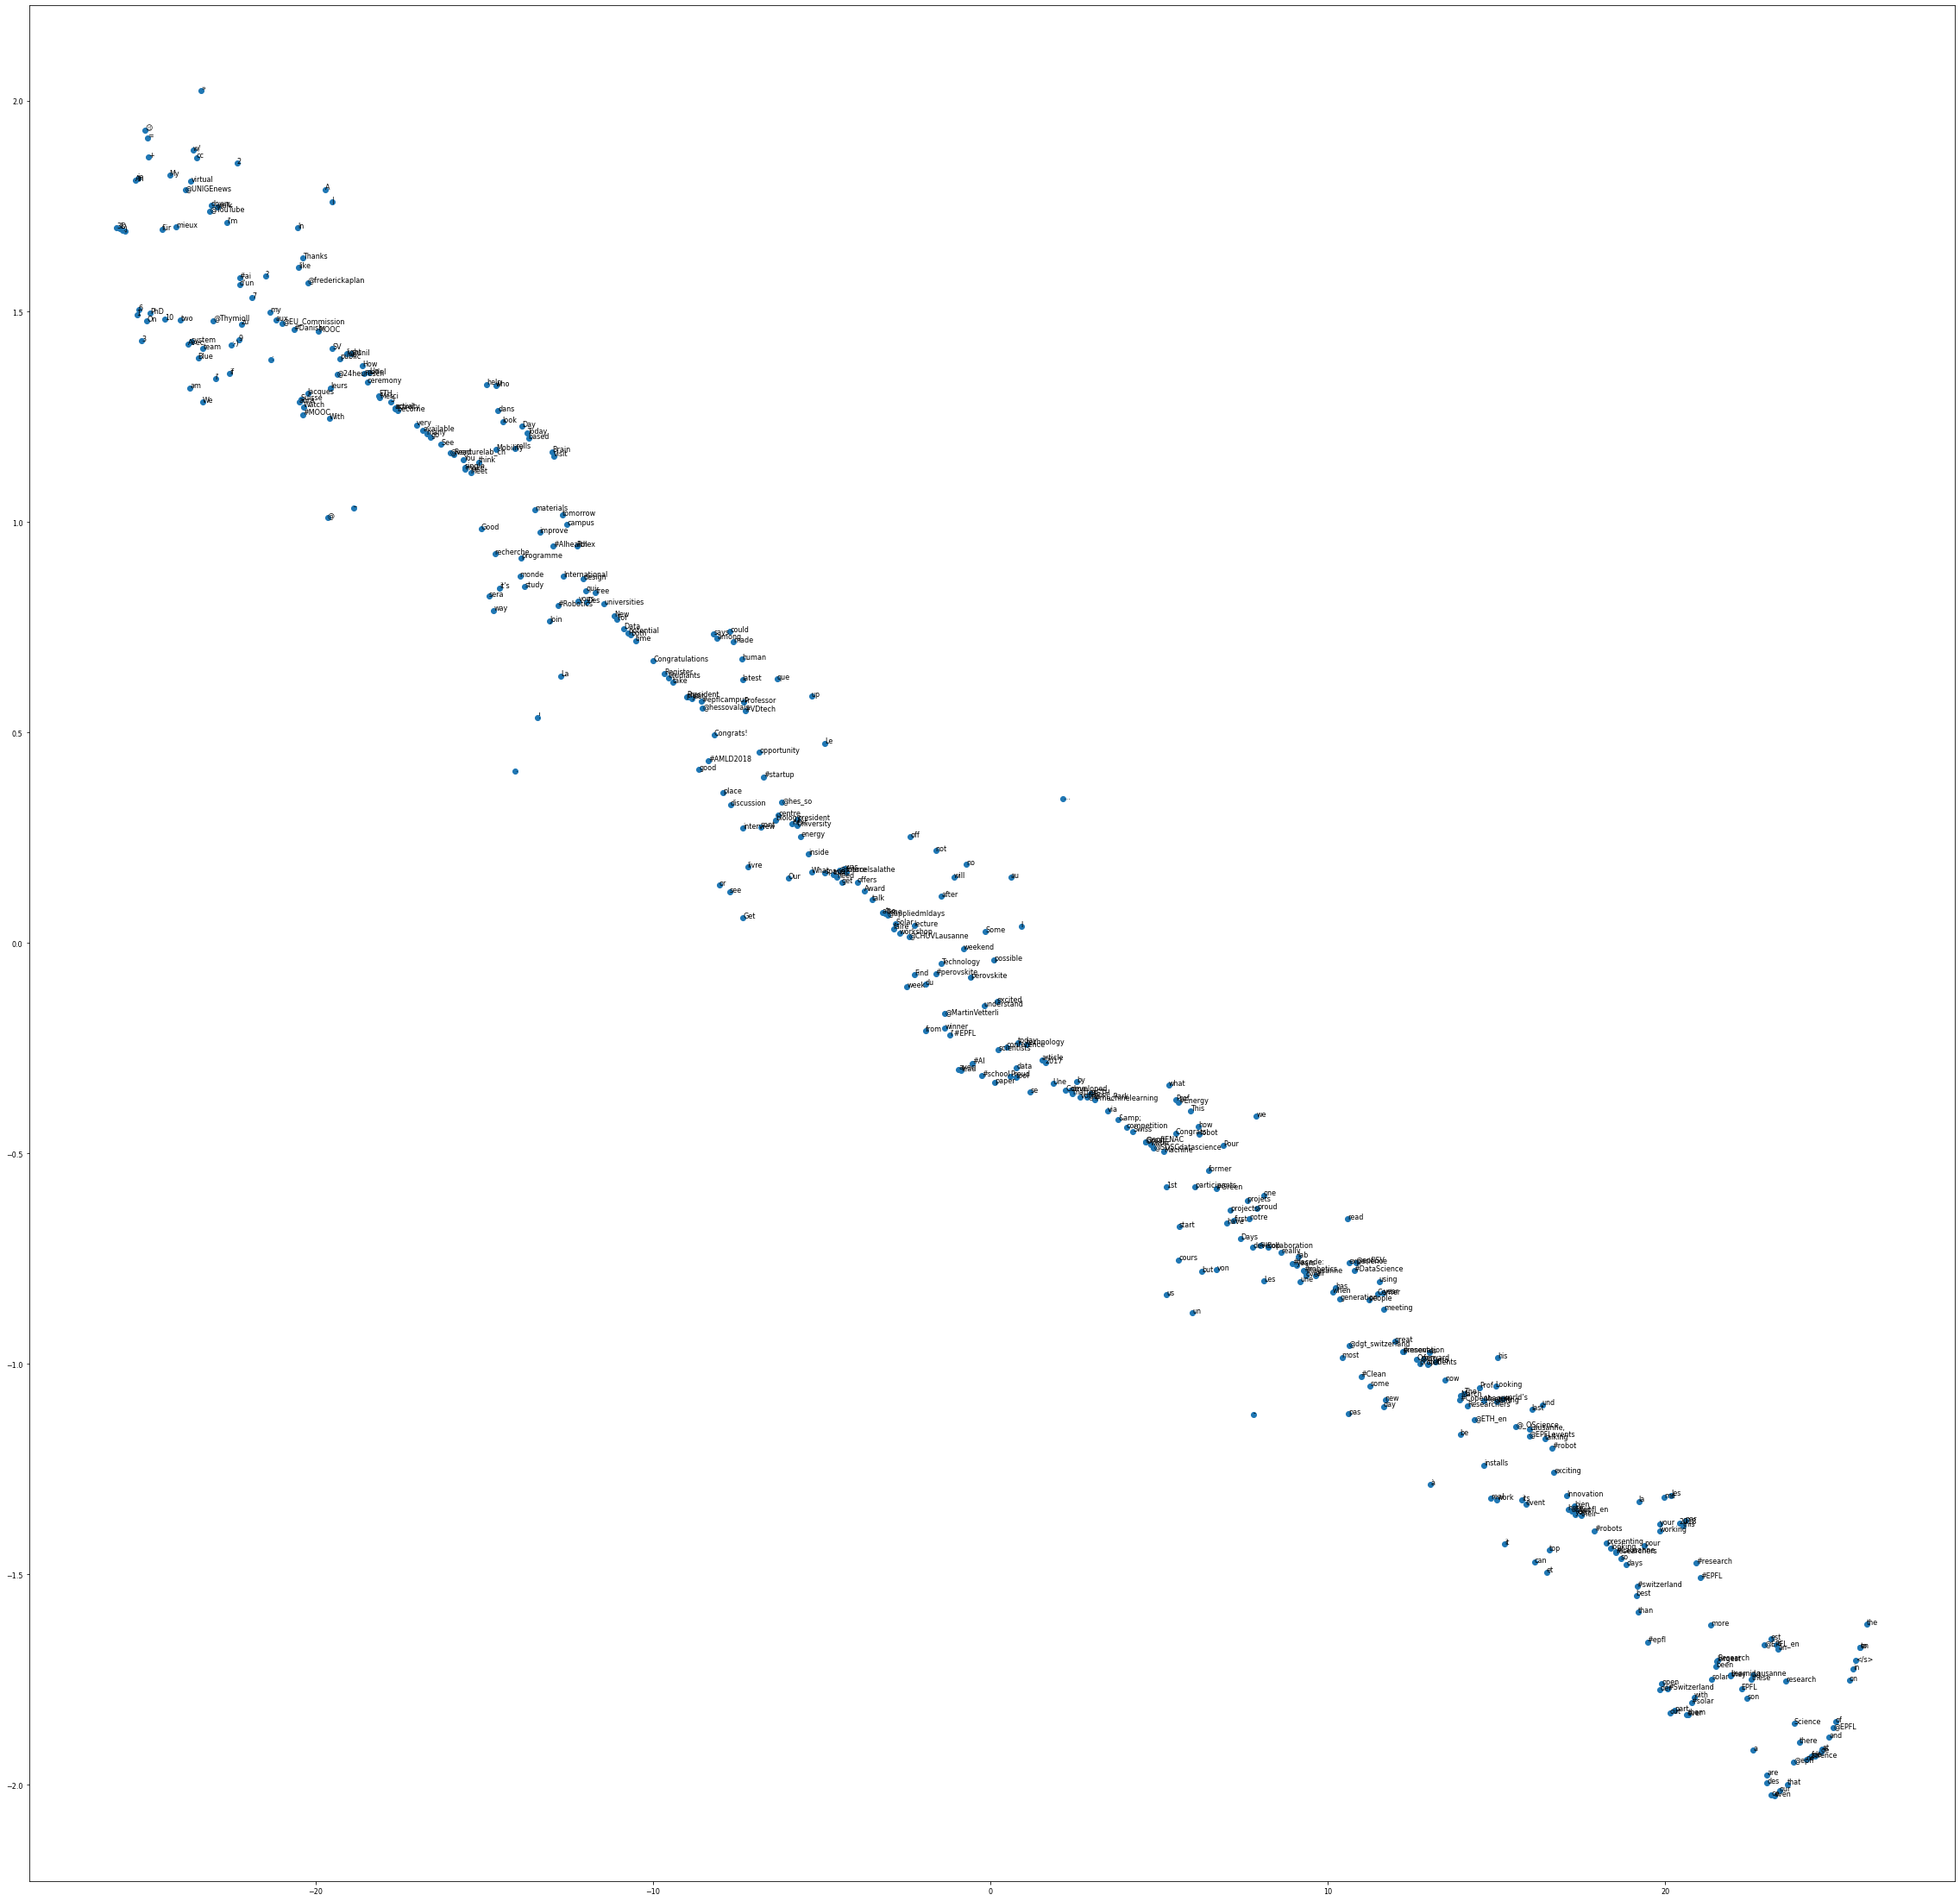

In [13]:
vis_data_x = vis_data[:,0]
vis_data_y = vis_data[:,1]

plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(40, 40)) 
plt.scatter(vis_data_x, vis_data_y)

for label, x, y in zip(vocabulary, vis_data_x, vis_data_y):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

### Questions:

1. Observe the plot of word embeddings. Do you observe any patterns?

- <b>You will not encounter a very obvious pattern (because the data is small and too much EPFL oriented) but some small patterns. </b>

    - Words are close to their context words i.e. Professor and MartinVetterli, President and MartinVetterli, Register and conference.

    - Similar words are clustered together: conference, workshop, discussion.

    - Stop words are not clustered together with other words because they cooccur with many words.

    - Artikels are close to each other (Une, du, des)

2. Write a python function to find the most similar terms for a given term. The similarity between two terms is defined as the cosine similarity between their corresponding word embeddings. Find the top 5 terms that are most similar to 'la', 'EPFL', '#robot', 'this'


In [14]:
from sklearn.metrics.pairwise import cosine_similarity

def find_most_similar(input_term, word_embeddings, vocabulary, num_terms=3):
    term_embeddings_dict = {}
    for i,term in enumerate(vocabulary):
        term_embeddings_dict[term] = word_embeddings[i]
        
    if input_term not in term_embeddings_dict:
        return "Term not in the vocabulary"
    
    input_term_embedding = term_embeddings_dict[input_term]
    term_similarities = []
    for term, embedding in term_embeddings_dict.items():
        term_similarities.append([term, cosine_similarity(input_term_embedding.reshape((1,-1)), 
                                                          embedding.reshape((1,-1)))])
        
    sorted_terms = sorted(term_similarities, key = lambda x: -1 * x[1])[0:num_terms]
    
    return sorted_terms

# Note:
# cosine_similarity takes a matrix (of all word vectors) as input,
# so it's better not to loop through all terms to computer term_similarities for efficieny reasons
# I avoided doing this in this part for better readability, 
# although you will see matrix based solution in get_most_similar_documents
# in any case, you will never need to compute similarities by yourself, instead you can use:
# import gensim
# model = gensim.models.KeyedVectors.load_word2vec_format('model.vec')
# similar = model.most_similar(positive=['epfl'],topn=10)

find_most_similar('EPFL', word_embeddings, vocabulary, num_terms=5)

[['EPFL', array([[0.99999994]], dtype=float32)],
 ['#EPFL', array([[0.99998516]], dtype=float32)],
 ['@EPFL', array([[0.999985]], dtype=float32)],
 ['@EPFLevents', array([[0.9999828]], dtype=float32)],
 ['@EPFL_en', array([[0.99998116]], dtype=float32)]]

## 📚 Exercise 2: Basic Search Engine Using Word Embeddings

In this exercise, we would put our word embeddings to test by using them for information retrieval. 
The idea is that, the documents that have the most similar embedding vectors to the one belongs to query should rank higher.
The documents may not necessarily include the keywords in the query.


### Goal:
1. Implement a search engine that uses word embeddings to retrieve relevant documents (Data file: `epfldocs.txt`)
2. Compare the results with vector space retrieval model


### What you are learning in this exercise:
- Learning to use word embeddings for a search engine 



### 1. Load the data

In [15]:
# Loading of libraries and documents
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
import math
from collections import Counter

# Read a list of documents from a file. Each line in a file is a document
with open("epfldocs.txt", ) as f:
    content = f.readlines()
        
original_documents = [x.strip() for x in content] 

### 2. Aggregate words of each document
Since both the documents and the query is of variable size, we should aggregate the vectors of the words in the query by some strategy. This could be taking the minimum vector, maximum vector or the mean. Fill in the code below.

In [16]:
# Create a dictionary of vectors for easier search
vector_dict = dict(zip(vocabulary, word_embeddings))

def aggregate_vector_list(vlist, aggfunc):
    if aggfunc == 'max':
        return np.array(vlist).max(axis=0)
    elif aggfunc == 'min':
        return np.array(vlist).min(axis=0)
    elif aggfunc == 'mean':
        return np.array(vlist).mean(axis=0)
    else:
        return np.zeros(np.array(vlist).shape[1])

possible_aggfuncs = ["max", "min", "mean"]

aggregated_doc_vectors = {}

# Aggregate vectors of documents beforehand
for aggfunc in possible_aggfuncs:
    aggregated_doc_vectors[aggfunc] = np.zeros((len(original_documents), word_embeddings.shape[1]))
    for index, doc in enumerate(original_documents):
        vlist = [vector_dict[token] for token in fasttext.tokenize(doc) if token in vector_dict]
        if(len(vlist) < 1):
            continue 
        else:
            aggregated_doc_vectors[aggfunc][index] = aggregate_vector_list(vlist, aggfunc) 
vlist

[array([ 0.04471834,  0.4892403 , -0.22380614, -0.50376064, -0.1463985 ,
         0.12763345, -0.05492915, -0.16907167,  0.4336451 ,  0.16843477,
         0.2177363 ,  0.35156438, -0.25857264,  0.12195172, -0.44452965,
         0.16301142, -0.57321316,  0.24433027, -0.12002349, -0.03483212,
         0.18931481,  0.04017151,  0.3446112 ,  0.06478363, -0.29550487,
        -0.2466975 ,  0.4750561 , -0.17728998,  0.08181842,  0.18024722,
         0.13321453,  0.23206306, -0.43678817,  0.08675779, -0.00674603,
         0.06246748,  0.38818163,  0.18350518, -0.14951985, -0.04913024,
        -0.21074033,  0.09175806, -0.40882128, -0.01998926, -0.00991959,
        -0.5085689 ,  0.06668596,  0.44191507,  0.12270255, -0.10846751,
         0.28472248,  0.09701806,  0.05441945,  0.57697093,  0.3359254 ,
        -0.1551831 , -0.2041676 ,  0.23349875,  0.4433968 ,  0.2925809 ,
         0.39988577, -0.30867493,  0.12240306,  0.48797515,  0.30256593,
         0.03309036, -0.2518893 , -0.00849912, -0.2

### 3. Aggregate the query
Aggregate the query and find the most similar documents using cosine distance between the query's vector and document's aggregated vector.

Are they seem to relevant?

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

query = "EPFL"

def aggregate_query(query, aggfunc):
    tokens = fasttext.tokenize(query)
    if(len(tokens) == 1):
        if(tokens[0] in vocabulary):
            return vector_dict[tokens[0]]
    elif(len(tokens) > 1):
        vlist = []
        for token in tokens:
            if (token in vocabulary):
                vlist.append(vector_dict[token])
        
        return aggregate_vector_list(vlist, aggfunc)
    else:
        print("%s is not in the vocabulary." % (query))
    
def get_most_similar_documents1(query_vector, aggfunc, k = 5):
    query_vector = query_vector.reshape(1, -1)
    # Calculate the similarity with each vector. 
    # Hint: Cosine similarity function takes a matrix as input so you do not need to loop through each document vector.
    sim = cosine_similarity(query_vector, aggregated_doc_vectors[aggfunc])
    
    # Rank the document vectors according to their cosine similarity with 
    indexes = np.argsort(sim, axis=-1, kind='quicksort', order=None) # This is sorted in ascending order
    indexes = indexes[0]
    indexes = indexes[::-1] # Convert to descending
    return indexes
def get_most_similar_documents2(query_vector, aggfunc, k = 5):
    # Calculate the similarity with each document vector. 
    # Hint: Cosine similarity function takes a matrix as input so you do not need to loop through each document vector.
    # TODO
    sim = cosine_similarity(aggregated_doc_vectors[aggfunc],query_vector.reshape(1,-1))
    sim_index = [(item,i) for i, item in enumerate(sim)]
    # Rank the document vectors according to their cosine similarity with the query vector and return topk indexes
    # TODO
    indexes = [item[1] for item in sorted(sim_index, key= lambda x: x[0], reverse=True)[:k]]
    # 直接获取index,还可以用argsort
    # 如果想reverse,[::-1] shorthand for [len(my_list)-1:0:-1] which means start from the last element, stop at the first element and step backwards by 1.

    return indexes

def search_vec_embeddings(query, topk = 10, aggfunc = 'mean'):
    query_vector = aggregate_query(query, aggfunc)
    indexes = get_most_similar_documents(query_vector, aggfunc, topk)
    # Print the top k documents
    indexes = indexes[0:topk]
    for index in indexes:
        print(original_documents[index])

In [31]:
search_vec_embeddings('EPFL', aggfunc = 'mean')

EPFL morning #epfl #lausanne #photography https://t.co/6IXddicblu
Die Onlineschule der @EPFL hat mit dem «Certificate of Open Studies» einen neuen akademischen Diplomtypus ins Leben gerufen | EPFL https://t.co/WzVUFMYxID #Weiterbildung #Diplom #COS
EPFL scientists developed self-healing materials inspired by plants. https://t.co/siauNzx3F8  via @EPFL_en #VDtech https://t.co/RyQo5Z3jhK
Congratulations EPFL Life Sciences Master students from your SV teachers (@befcorreia,Hantschel,@MBlokesch) @EPFL_en @epflSV #Magistrale2017 https://t.co/0giVobWPuo
Red Line #Drone Delivery Concept For #Africa by EPFL &amp; Norman Foster #transportation #affordable https://t.co/BWArZzxaya #epfl #epflcampus
EPFL is joining the Global Entrepreneurship Week next Tuesday! Learn more and join us https://t.co/Piz1hi72jt  #GEWCH2017 #VDtech @EPFL_en https://t.co/Wejk5IWILc
Nicolas Mounet from EPFL @EPFL talking about two-dimensional materials and high-throughput calculations at #MaXConf2018 in Trieste @aiidateam

### 4. Compare the results with the vector space retrieval

In [32]:
# VECTOR SPACE RETRIEVAL (From Exercise 1)
# Retrieval oracle 
from operator import itemgetter
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 1, stop_words = 'english')
features = tf.fit_transform(original_documents)
npm_tfidf = features.todense()

# Return all document ids that that have cosine similarity with the query larger than a threshold
def search_vec_sklearn(query, topk = 10, features = features, threshold=0.1):
    new_features = tf.transform([query])
    print(new_features.shape)
    cosine_similarities = linear_kernel(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1), 
                                                       reverse=True))
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold or i >= topk:
            break
        doc_ids.append(related_docs_indices[i])
    
    for index in doc_ids:
        print(original_documents[index])

In [33]:
search_vec_embeddings('EPFL', aggfunc = 'mean')
print("---------------------------------")
search_vec_sklearn("EPFL")

EPFL morning #epfl #lausanne #photography https://t.co/6IXddicblu
Die Onlineschule der @EPFL hat mit dem «Certificate of Open Studies» einen neuen akademischen Diplomtypus ins Leben gerufen | EPFL https://t.co/WzVUFMYxID #Weiterbildung #Diplom #COS
EPFL scientists developed self-healing materials inspired by plants. https://t.co/siauNzx3F8  via @EPFL_en #VDtech https://t.co/RyQo5Z3jhK
Congratulations EPFL Life Sciences Master students from your SV teachers (@befcorreia,Hantschel,@MBlokesch) @EPFL_en @epflSV #Magistrale2017 https://t.co/0giVobWPuo
Red Line #Drone Delivery Concept For #Africa by EPFL &amp; Norman Foster #transportation #affordable https://t.co/BWArZzxaya #epfl #epflcampus
EPFL is joining the Global Entrepreneurship Week next Tuesday! Learn more and join us https://t.co/Piz1hi72jt  #GEWCH2017 #VDtech @EPFL_en https://t.co/Wejk5IWILc
Nicolas Mounet from EPFL @EPFL talking about two-dimensional materials and high-throughput calculations at #MaXConf2018 in Trieste @aiidateam

### Question
You will realize that not all the words in your queries are in the vocabulary, so your queries fail to retrieve any documents. Think of possible solutions to overcome this problem.

1. Use a bigger corpus
2. Try pretrained vectors (check glove)
3. Preprocess (lowercase, stem) (if the former 2 options are not available)
4. Use heuristics to find similar words and aggregate their vectors, i.e. get a word in the query's stem and the words that have the same stem, get the words with close edit distance to catch hashtags and mentions etc.
    Some examples:
    * MAGA -> What it stands for: Make America Great Again (What MAGA stands for)
    * MAGA -> Cooccuring words, i.e. TCOT (Top Conservatives on Twitter, likely precedes the slogan MAGA)
    * MAGA -> words of concept (Republican) = {Tcot, PJNET, Republic etc.} use the concept vector / average of the word vectors' belonging to that concept. Use wordnet (https://wordnet.princeton.edu) but no MAGA unfortunately :(
5. Search the literature for more ideas.